# AP4 - Apprentissage machine et classification d'ondes cérébrales

## Définition du problème

Avant de se lancer directement dans les données, il faut déjà savoir quelles caractéristiques du signal on compte utiliser et choisir un modèle adapté.

Tout les algorithmes d'apprentissage automatique ne sont pas égaux face à différents jeux de données. Par exemple, les forêts et arbres de classification sont plus efficaces sur des données avec beaucoup de caractéristiques que les SVM qui souffriront bien plus du fléau de la dimensionalité.

Il faut aussi se demander si la quantité de données est suffisante pour l'hypothèse que l'on veut vérifier. Même si on peut parfois utiliser des tests statistiques pour valider un résultat obtenu avec peu de données. Comme en neuroscience, les données dont souvent coûteuses et donc souvent peu nombreuses il n'est pas rare de devoir avoir recours à de l'augmentation de données pour y pallier.

Dans le cas présent, nous allons explorer différents designs pour essayer de résoudre différents problèmes sur un même jeu de données.

Pour se faire, on va utiliser la librairie <a href="">sklearn</a> qui va nous permettre d'utiliser certains algorithmes d'apprentissagge machine assez simplement.

### Installation des librairies nécessaires:

In [1]:
!pip install scikit-learn==1.0.1 numpy matplotlib mne

### Imports

In [2]:
import os.path as op
import numpy as np
import mne
from matplotlib import pyplot as plt

%matplotlib inline

## Classification gauche-droite

Premièrement nous allons nous intéresser à effectuer une classification de nos données qui nous permettra de détecter si le sujet à entendu un stimulus à gauche ou bien à droite. Dans une approche guidée par les données (data driven), nous n'allons pas émetre d'hypothèse au préalable sur les résultats. 

On va, pour chaque capteur, essayer de faire la différence entre stimulus gauche et stimulus droit, en utilisant les valeurs de PSD calculées dans l'AP3.

### Chargement des données

Les classifications sont des méthodes d'apprentissage machine dites supervisées et nécessitent l'utilisation de deux matrices:
- une matrice data souvent appelée X, qui contient les données que l'on va utiliser pour l'apprentissage et le test de l'algorithme d'apprentissage machine.
- Une matrice "labels" ou "targets" souvent appelée y, qui contient l'information que l'on souhaite prédire encodée en chiffres.

Dans notre exemple, comme nous souhaitons classifier entre stimulus gauche ou droite, on va arbitrairement associer 0 ou 1 à chacune de nos classes. Par exemple: 0 <=> gauche ; 1 <=> droite.

In [3]:
conditions = ['visualleft', 'visualright']
data_path = mne.datasets.sample.data_path()
data = []
targets = []
for i, condition in enumerate(conditions):
    temp_data = np.load(op.join(data_path, 'MEG', 'sample', f'{condition}_psds_bands.npy'))
    targets += [i]*temp_data.shape[1]
    data.append(temp_data)

X = np.concatenate(data, axis=1)
y = np.array(targets)

### Choix de l'algorithme

Pour commencer, nous allons utiliser K Nearest Neighbors (KNN). Un algorithms simple, rapide en exécution qui possède un seul hyper-paramètre.

Dans un premier temps, on va évaluer les performances de l'algorithme sans se soucier d'optimiser les hyper-paramètres, mais on reviendra sur ce concept plus tard.

In [4]:
from sklearn.neighbors import KNeighborsClassifier as KNN

clf = KNN()

### Choix de la méthode de validation

Il nous faut maintenant choisir une méthode qui nous permettra de mieux évaluer les performances de notre algorithme. Le choix de cette méthode est important car si la méthode de validation est mal choisie, elle pourrait impacter nos résultats. 

Cette méthode va dicter la façon dont on va séparer nos données afin d'entraîner notre algorithme sur une partie et de tester sur une autre. Elle est nécessaire car sans elle, nous ne pourrions pas controller le sur-apprentissage (overfitting).

La méthode la plus simple qui existe est de séparer nos données en deux partie: entraînement (train) et validation ou test ce que l'on appelle la "Holdout method":

#### Holdout method

Coupons arbitrairemement les données en 2:

In [5]:
X_train = X[:72]
y_train = y[:72]

X_test = X[72:]
y_test = y[72:]

Immédiatement, si on affiche les labels de nos données on se rend compte d'un problème: notre sous-ensemble d'etraaînement ne contient que des exemples de stimuli à gauche et sera donc incapable d'apprendre comment différentier droite de gauche!

In [6]:
print(y_train)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Il nous faut donc prendre au hasard des exemples du jeu de données initial ou encore le mélanger avant de tirer les exemples.

Pour ce faire, on créé un index des données sur lequel on va effectuer le mélange afin de pouvoir effectuer exactement le même mélamge sur les labels. Sans quoi on perdrait la correspondance entre exemple et sa catégorie:

In [7]:
# Création de l'index:
index = np.arange(X.shape[1])

# mélange de l'index:
np.random.shuffle(index)

# On applique le mélange aux données et aux labels:
shuffled_X = X[:,index]
shuffled_y = y[index]

# On effectue notre séparation (split) à nouveau:
X_train = shuffled_X[:,:72]
y_train = shuffled_y[:72]

X_test = shuffled_X[:,72:]
y_test = shuffled_y[72:]

# Affichons à nouveau nos labels d'entraînement pour vérifier:
print(y_train)

[1 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0
 0 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0]


En pratique, sklearn implémente des fonctions qui vont permettre de faciliter ce travai:

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.swapaxes(0,1), y, test_size=72, random_state=42)
X_train = X_train.swapaxes(0,1)
X_test = X_test.swapaxes(0,1)

print(y_train)

[0 1 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 1 1 1
 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1]


<b>Note</b>: Ici on est obligé d'utiliser <a href="https://numpy.org/doc/stable/reference/generated/numpy.swapaxes.html">swapaxes</a> car il faut que la première dimension de nos données soit la dimension qui liste les exemples. Or actuellement, la première dimentsion est la dimension des électrodes.

<b>Note</b>2: Étant donné que le mélange des données est aléatoire, il est toujours possible par malchance d'avoir un split qui favorise une classe dans X_train et y_train, cela peut être contrôlé en utilisant une option de la fonction. Voir la <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">doc</a>

<b>Note</b>3: On obtient un mélange différent à chaque exécution du code. Le mélange peut être controllé si on désire pouvoir reproduire exactement la même expérience en fixant un "random_state". Voir <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.htm">doc</a>

Évaluons maintenant les performances de notre modèle sur notre problème. Ce qui nous intéresse, c'est de savoir quelle(s) électrode(s) permet le mieux de faire la différence entre stimuli gauche ou droite. Intéressons nous d'abord par la première de la liste.

In [9]:
electrode = 0

Entraînons le modèle sur le dataset d'entraînement:

In [10]:
clf.fit(X_train[electrode], y_train)

KNeighborsClassifier()

Et utilisons le modèle entraîné pour prédire les classes du dataset de test:

In [11]:
y_pred = clf.predict(X_test[electrode])
print(y_pred)

[0 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1
 0 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 1]


Pour mesurer les performances de notre algorithme nous pouvons simplement calculer son erreur et sa précision: pour ce faire, il suffit de calculer erreur = Somme(valeur_absolue(y_pred - y_test)) / nombre_de_predictions

puis accuracy = 1 - erreur

In [12]:
error = sum(abs(y_pred - y_test)) / len(y_pred)
accuracy = 1 - error
print(accuracy)

0.5138888888888888


Notre score est de 45.8% de précision (accuracy). Il existe d'autres mesures de performance du modèle, mais dans notre cas, la précision est adaptée.

Comme notre problème est un problème de classification binaire, le niveau de chance théorique est à 50%, cela veut dire que notre résultat est juste en dessous du niveau de chance et donc, que notre modèle n'est probablement pas capable de faire la différence entre stimulus gauche et droite avec ces caractéristiques du signal là à cette électrode là. 

Cependant, étant donné que nous avons un petit nombre de données, le niveau de chance théorique n'est pas le niveau de chance auquel on devrait comparer les performances de notre modèle. Il faut vérifier la pertinence statistique de ce résultat. Nous reviendrons sur cette partie plus tard.

Pour voir plus de métriques de performances, voir <a href="https://en.wikipedia.org/wiki/Fairness_(machine_learning)">ici</a>

Encore une fois, en pratique il est beaucoup plus simple d'utiliser directement une fonction donnée par sklearn pour calculer la précision de notre modèle:

In [13]:
score = clf.score(X_test[electrode], y_test)
print(score)

0.5138888888888888


Il ne nous reste donc plus qu'à répéter ces dernières opérations pour chaque électrode et de vérifier la pertinence statistique de nos résultats.

Seulement, le problème de la "Holdout method" est que si on l'utilise sur un petit jeu de données, il est possible que cette séparation nous avantage ou désavantage dans l'évalutation des performances de notre algorithme par chance uniquement. Pour remédier à celà, on utilise des méthodes de "cross-validation". Une cross-validation va répéter le processus de découpage des donées plusieurs fois afin de limiter l'impact du facteur chance au minimum.

### Cross-validation: K-Fold

Voilà quelques méthodes de cross-validation communes:
- Leave One Out (LOO)
- Leave P Out (LPO)
- K-Fold

LOO consiste à laisser de côté un seul exemple de notre jeu de données pour le test et de garder tout le reste pour l'entraînement. Bien que cette méthode permette de mesurer avec précision la performance d'un algorithme, elle est rarement utilisée en pratique. En effet, cette méthode est exhaustive, ce qui veut dire qu'elle va essayer toutes les combinaisons prossibles de train et de test sets. Ce n'est pas un problème dans notre cas vu que notre jeu de données est relativement petit (seulement 140 exemples), mais cela peut devenir un problème quand on possède des millions d'exemples et que effectuer l'entrainement et le test de l'algorithme prend un certain temps.

LPO est basée sur le même principe que LOO et est exhaustive. Cette méthode à l'avantage de tester sur plusieurs exemples au lieu d'un à chauque itération et est donc encore plus précise, mais elle souffre encore plus d'une augmentation de la taille des données, vu qu'il y a encore plus de combinaisons de p parmis n que de 1 parmis n.

K-fold consiste à couper les données en K sous-parties, de combiner K-1 sous parties pour constituer le train set et d'utiliser la dernière sous partie comme test set. Cette méthode est souvent préférée puisque beaucoup plus rapide que les précédentes quand on à accès à beaucoup de données tout en donnant une idée acceptable de la performance de l'algorithme.

Nous allons utiliser K-Fold puisque cette méthode est plus rapide tout en restant adaptée à notre problème.
En pratique on utilise la verison "stratifiée" de K-Fold afin de s'asurer que chacune des sous-parties du dataset contient bien autant d'exemples de chaque condition. Sans cela, il serait possible par malchance d'avoir quelques sous-parties des données qui ne contiennent qu'une conditon, ce qui fausserai les résultats.

On va choisir la valeur par défaut K = n_splits = 5, qui nous permettra d'avoir 5 scores de précision de notre algorithme entrainé sur K-1 = 4 / 5 = 80% de nos données et testé sur les 1/5 = 20% restantes.

In [14]:
from sklearn.model_selection import StratifiedKFold as SKFold

cv = SKFold(n_splits=5)

Concrètement, ce que cette méthode va faire, c'est effectuer plusieures fois le train/test split que nous avons effectué plus haut manuellement.

De cette façon, au lieu d'obtenir un score unique de précision pour une électrode, on peut en obtenir plusieurs et les moyenner afin d'avoir un résultat plus robuste. 

Si on effectue une étape de cross-validation avec notre objet cv, on peut reproduire ce qu'on a fait plus haut:

In [15]:
train_index, test_index = next(cv.split(X[electrode], targets))
X_train = X[electrode][train_index]
y_train = y[train_index]
X_test = X[electrode][test_index]
y_test = y[test_index]

clf = KNN()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.3103448275862069

On veut reproduire la cellule précédente pour chaque sous-set de données, il faut juste enregistrer les résultats dans une liste au fur et à mesure:

In [16]:
scores = []
for train_index, test_index in cv.split(X[electrode], y):
    X_train = X[electrode][train_index]
    y_train = y[train_index]
    X_test = X[electrode][test_index]
    y_test = y[test_index]
    
    clf = KNN()
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

print(scores)

[0.3103448275862069, 0.3793103448275862, 0.5172413793103449, 0.41379310344827586, 0.5357142857142857]


On obtient bien 5 scores, pour les 5 splits que nous avions paramétrés dans l'objet cross-validation.

On remarque ici que en fonction du split, le score de précision de notre modèle varie beaucoup ! On se rend compte aussi que nous avions eu de la chance avec notre précédent score de 45.8% et que nous avons bien fait de changer de méthode de validation. Il faut noter aussi que la taille du train set était différente dans notre précédente expérience avec la Holdout method, ce qui peut avoir un impact sur le score final du modèle.

Calculons le score de précision moyen de notre modèle pour la première électrode:

In [17]:
score_moyen = np.mean(scores)
print(score_moyen)

0.43128078817733984


Notre score moyen est bien en dessous du niveau de chance ! On peut presque conclure que cette électrode ne capture pas d'informations pertinentes pour faire la différence entre stimulus gauche ou droite.

Pour aller plus loin dans notre analyse, il faut maintenant calculer la précision de notre modèle pour chaque électrode, mais avant, nous allons utiliser une fonction plus haut niveau de sklearn qui va nous permettre de simplifier notre code puisqu'elle permet d'effectuer la cross-validation en une seule ligne:

In [18]:
from sklearn.model_selection import cross_val_score

clf = KNN()
cv = SKFold(n_splits=5)
scores = cross_val_score(clf, X[electrode], y, cv=cv)
print(np.mean(scores))

0.43128078817733984


On peut maintenant calculer le score de précision de notre modèle sur ces données pour chaque électrode:

In [19]:
n_elec = len(X)

scores_elec = []
for electrode in range(n_elec):
    clf = KNN()
    cv = SKFold(n_splits=5)
    scores = cross_val_score(clf, X[electrode], y, cv=cv)
    scores_elec.append(np.mean(scores))
    
scores_elec = np.array(scores_elec)

Visualisons les résultats que l'on a obtenu sur une topomap:

Opening raw data file /home/arthur/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.


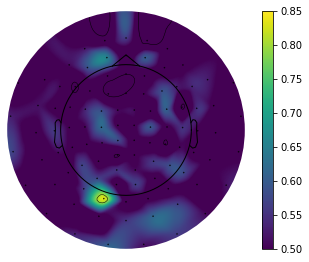

In [20]:
import mne
from mne.viz import plot_topomap

# Chargement des données de potition des capteurs:
data_path = mne.datasets.sample.data_path()
raw = mne.io.read_raw_fif(
    op.join(data_path, 'MEG', 'sample', 'sample_audvis_raw.fif'), preload=False)
info = raw.pick_types(meg='mag').info

# Création et affichage de la topomap:
fig, ax = plt.subplots()
im, cn = plot_topomap(
    scores_elec,
    info,
    res=128,
    cmap="viridis",
    vmax=.85,
    vmin=.50,
    show=False,
    show_names=False,
    contours=1,
    extrapolate="head",
)
cb = fig.colorbar(im)


On remarque qu'il semble que l'on aurait de bons résultats dans l'ère occiptiale. Il n'est pas encore possible de conclure avand d'avoir effectué des tests statistiques, même si ces résultats sont une bonne indication que tout a bien fonctionné. Voyons donc quel est notre plus haut score:

In [21]:
print(max(scores_elec))

0.8334975369458126


Avant d'effectuer des tests statistiques, nous allons créer une matrice de confusion pour voir si on peut avoir des informations supplémentaires sur l'électrode sur laquelle notre modèle obtient des meilleures performances.

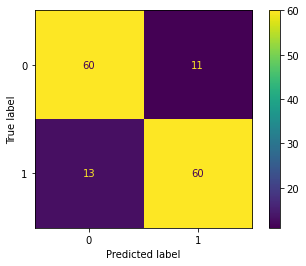

In [22]:
# Obtenir l'index de l'électrode qui donne la meilleure précision:
best = np.argmax(scores_elec)

# création des données nécessaires pour la matrice de confusion, 
# il nous faut les prédictions et les labels originaux de tous nos splits de K-Fold:
cv = SKFold(n_splits=5)
y_true, y_pred = [], []
for train_index, test_index in cv.split(X[best], y):
    X_train = X[best][train_index]
    y_train = y[train_index]
    X_test = X[best][test_index]
    y_test = y[test_index]
    
    clf = KNN()
    clf.fit(X_train, y_train)
    y_pred += list(clf.predict(X_test)) # additionner des listes revient à les concaténer
    y_true += list(y_test)

# import de la fonction confusion_matrix de sklearn:
from sklearn.metrics import ConfusionMatrixDisplay as CM

# utilisation de la fonction:
CM.from_predictions(y_pred, y_true)
plt.show()

On ne remarque pas d'imbalance particulière dans la matrice de confusion. La matrice de confusion donne des informations supplémentaires quant à la spécificité et la sensibilité du modèle. Pour en savoir plus, cliquez [ici](https://fr.wikipedia.org/wiki/Sensibilit%C3%A9_et_sp%C3%A9cificit%C3%A9)

### Tests statistiques

En science des données il est généralement recommandé d'avoir un grand nombre de données pour pouvoir mieux modéliser et comprendre un phénomène. Malheureusement dans les sciences médicales, les données sont souvent rares et chères. Pour pallier ce problème, on peut utiliser des tests statistiques qui vont nous permettre de prouver que notre résultat n'est pas le produit de la chance.

Une première approche est plus théorique et repose sur la loi binomiale, qui permet d'évaluer la probabilité d'effectuer une série spécifique d'évènement pour une variable aléatoire avec une densité de probabilité donnée. Par exemple, cette loi permet de calculer la probabilité de n'obtenir qu'une seule fois face dans une série de N tirages à pile ou face.
Comme nous effectuons une classification binaire, nous pourrions utiliser cette loi afin de savoir à quel point il est rare d'obtenir notre précision maximale de 83% si nous tirions à pile ou face les conditions pour chaque exemple de notre jeu de données.

Une autre méthode plus pratique consiste à effectuer des permutations de nos labels y afin de voir combien de fois il est possible d'obtenir notre résultat avec notre modèle uniquement par la chance. 

Nous allons nous concentrer sur la deuxième méthode qui est plus fiable et intuitive, mais prend aussi plus de temps à calculer. En pratique, plus le nombre de permutations est grand, plus on pourra affirmer que notre résultat est fiable. Dans le cadre de ce tutoriel nous n'allons effectuer que 100 permutations pour pouvoir voir nos résultats avant que le soleil ne s'éteigne.

In [ ]:
# reprenons d'abord notre code précédent, qu'il faudra exécuter 100 fois en mélangeant à chaque fois les labels y.
n_permutations = 100
perm_scores = []
for i in range(n_permutations-1):
    n_elec = len(X)

    pscores_elec = []
    for electrode in range(n_elec):
        clf = KNN()
        cv = SKFold(n_splits=5)
        np.random.shuffle(y) # ici on mélange les labels
        pscores = cross_val_score(clf, X[electrode], y, cv=cv)
        pscores_elec.append(np.mean(pscores))
        
    perm_scores.append(np.array(pscores_elec))
perm_scores = np.array(perm_scores)

Affichons les performances de notre modèle afin de mieux voir notre niveau de chance pour notre meilleure électrode.

In [ ]:
plt.hist(perm_scores[:,best])
plt.show()

Avec seulement 100 permutations, l'histogramme des scores de précision est relativement loin de la distribution réelle des scores de précisions possibles. Avec un nombre infini de permutations, l'histogramme convergerai vers une gaussienne centrée sur le niveau de chance. Cependant, on remarque que notre score est bien supérieur aux 100 scores de permutations:

In [ ]:
print(scores_elec[best] > max(perm_scores[:,best]))

On peut donc affirmer que notre résultat est significatif à p=0.01.

Afin de le confirmer et renforcer encore notre résultat, il convient de vérifier que notre score est le meilleur de toutes les permutations à travers toutes les électrodes. C'est ce que l'on appelle la correction par le maximum statistique.

Il existe d'autres méthodes de correction de pvalues comme la méthode de [bonferroni](https://www.itl.nist.gov/div898/handbook/prc/section4/prc473.htm), qui est plus stricte.

In [ ]:
# ravel sert à applatir une matrice. Ici, on l'utilise pour se débarasser de la dimension "electrode" 
# de notre matrice de résultats. Ce faisant, on compare notre score à la distribution de tous les scores
# de permutation à travers toutes les électrodes.
plt.hist(perm_scores.ravel())
plt.show()
print(scores_elec[best] > max(perm_scores.ravel()))

Notre résultat est significatif à p=0.01 avec correction par le maximum statistique.

Nous allons maintenant créer un masque de tous nos résultats significatifs à p=0.01 et les afficher à travers un masque sur notre topomap des decoding accuracies.

In [ ]:
# création du masque
mask_params = dict(
    marker="*", markerfacecolor="white", markersize=9, markeredgecolor="white"
)
tt_mask = np.full((len(X)), False, dtype=bool)
tt_mask[scores_elec > max(perm_scores.ravel())] = True

# Création et affichage de la nouvelle topomap:
fig, ax = plt.subplots()
im, cn = plot_topomap(
    scores_elec,
    info,
    res=128,
    cmap="viridis",
    vmax=.85,
    vmin=.50,
    show=False,
    show_names=False,
    mask=tt_mask, # On ajoute simplement ces deux lignes pour y inclure le masque
    mask_params=mask_params, # deuxieme ligne ajoutee au code topomap précédent
    contours=1,
    extrapolate="head",
)
cb = fig.colorbar(im)

On voit que notre seul résultat significatif à p=0.01 est notre meilleur résultat.

## Conclusion

Afin d'améliorer encore nos résultats, il serait intéressant d'effectuer une optimisation des hyper-paramètres, ce qui est en dehors de la portée de ce tutoriel. Pour rester concis, cela demanderai de refaire les étapes de classifications et d'évaluation de notre modèle pour différentes valeurs de K sur un sous jeu du set de donnée d'entrainement. Cela nous mènerai à utiliser une cross-validation à l'intérieur de notre cross-validation, ce que l'on appelle alors des [nested cross-validations](https://www.analyticsvidhya.com/blog/2021/03/a-step-by-step-guide-to-nested-cross-validation/).

Dans un second temps, essayer d'autres modèles qui seraient potentiellement plus efficaces à décoder la différence entre stimulus "droite" vs stimulus "gauche" pourrait être intéressant.

Il serait aussi intéressant d'explorer l'impact de chacune des bandes de fréquences utilisées dans notre classification. En effet, jusque maintenant, nous avons utilisé les quatre bandes sans se soucier de la contribution de chacune d'entre elles. C'est ce que l'on appelle une approche "multi-feature". Nous pourrions effectuer la classification sur chaque bande de fréquence individuellement et conclure de l'importance de chaque bande de fréquence pour la classification stimulus visuel droite vs stimulus visuel gauche.

Nous pourions aussi utiliser d'autres caractéristiques du signal, d'autre combinaisons de ces caractéristiques, augmenter le nombre de données et utiliser les données de plusieurs sujets afin a'avoir un résultat plus robuste et généralisable... Les possibilités ne manquent pas en recherche. Juste le temps et les cerveaux :)